# Introduction to Telstra competition


This is the dataset that is used in the Telstra Network Disruptions competition that ran between Nov 2015 and Feb 2016
This competition provided a very nice and small dataset that allows many aspects of predictive modelling:

* relational data between different entities of the disruption data
* clean dataset that provides consistent and reliable feedback
* ideal for practices for many parts of the predictive modelling pipelin: feature engineering, cross-validation, stacking, etc
* Magic Feature! see forum thread for more details :)
* This dataset is re-uploaded since the original competition did not feature kernels, and it is made available here give people a chance to practice their data science/predictive modelling skill with this nice little dataset

# content




* The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files.

* Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many).

* Different types of features are extracted from log files and other sources: eventtype.csv, logfeature.csv, resourcetype.csv, severitytype.csv.

* Note: “severitytype” is a feature extracted from the log files (in severitytype.csv). Often this is a severity type of a warning message coming from the log. "severitytype" is categorical. It does not have an ordering. “faultseverity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).

In [1]:
# Load the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf                      # to allow RNN models
%matplotlib inline

# Load the data

In [2]:
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
sample_submission = pd.read_csv('sample_submission.csv')
severity_type = pd.read_csv('severity_type.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [4]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [5]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [6]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


In [7]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


# 1. Lets do Exploratory data analysis ( EDA )

## analyse Train set

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7381 non-null   int64 
 1   location        7381 non-null   object
 2   fault_severity  7381 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.1+ KB


In [9]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [10]:
len(train.index)

7381

In [11]:
len(train.id.unique())

7381

In [12]:
len(train.location.unique())

929

In [13]:
len(train.fault_severity.unique())

3

In [14]:
train.isnull().sum()

id                0
location          0
fault_severity    0
dtype: int64

## Analysis Test set

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11171 non-null  int64 
 1   location  11171 non-null  object
dtypes: int64(1), object(1)
memory usage: 174.7+ KB


In [16]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [17]:
len(test.index)

11171

In [18]:
len(test.id.unique())

11171

In [19]:
len(test.location.unique())

1039

In [20]:
test.isnull().sum()

id          0
location    0
dtype: int64

# combining training and test data into a single data set

In [21]:
# creating a colum of istrain in both train and test data

train['istrain'] = 1
test['istrain'] = 0

data = train.append(test)

# analysis data

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18552 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              18552 non-null  int64  
 1   location        18552 non-null  object 
 2   fault_severity  7381 non-null   float64
 3   istrain         18552 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 724.7+ KB


In [23]:
data.head()

,id,location,fault_severity,istrain
0,14121,location 118,1.0,1
1,9320,location 91,0.0,1
2,14394,location 152,1.0,1
3,8218,location 931,1.0,1
4,14804,location 120,0.0,1


In [24]:
print('total number of rows in data: ' , len(data.index))
print('number of unique id :' , len(data.id.unique()))
print('number of unique locations:' , len(data.location.unique()))
print('number of unique fault severity:' , len(data.fault_severity.unique()))

total number of rows in data:  18552
number of unique id : 18552
number of unique locations: 1126
number of unique fault severity: 4


In [25]:
data.isnull().sum()

id                    0
location              0
fault_severity    11171
istrain               0
dtype: int64

# cleaning the data

In [26]:
# we will strip the location attribute and maintain the interger value of location

data.location = data.location.str.lstrip('location').astype('int')
data.head()

,id,location,fault_severity,istrain
0,14121,118,1.0,1
1,9320,91,0.0,1
2,14394,152,1.0,1
3,8218,931,1.0,1
4,14804,120,0.0,1


# visualizing the data

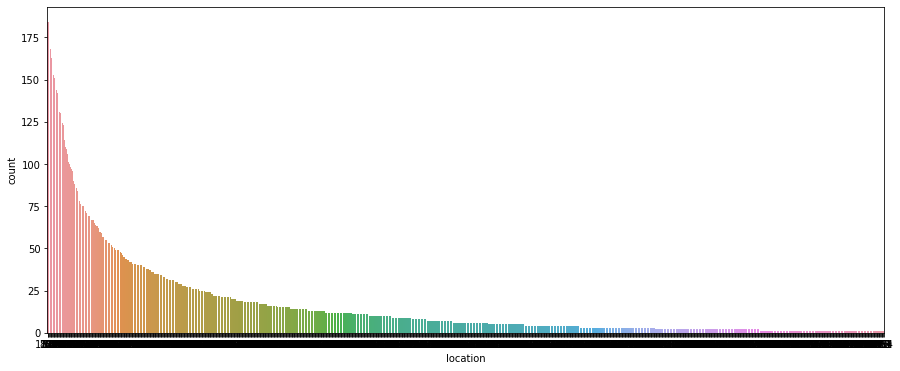

In [27]:
plt.figure(figsize=(15,6))
col = 'location'
sns.countplot(x = col , data = data , order=data[col].value_counts().index)

Text(0, 0.5, 'frequency')

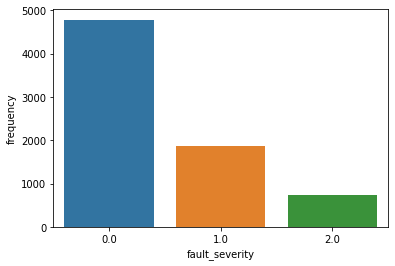

In [28]:
sns.countplot(x = 'fault_severity' , data = data)
plt.ylabel('frequency')

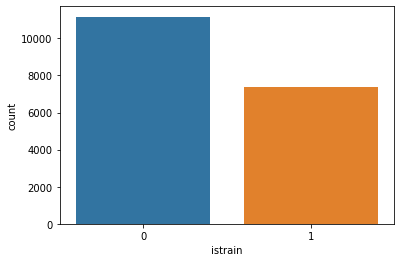

In [29]:
sns.countplot(x = 'istrain' , data = data)

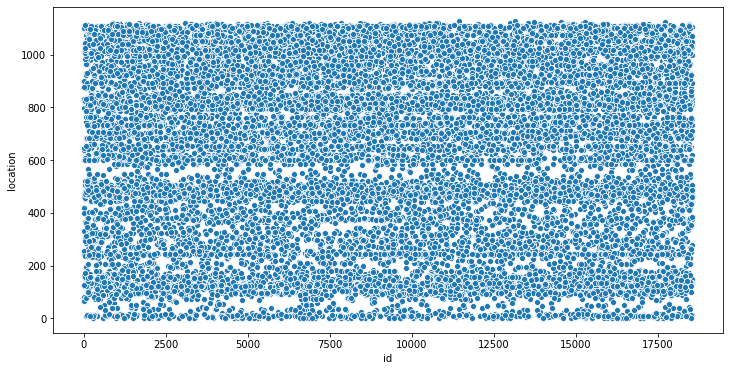

In [30]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'id' , y='location' , data= data  , cmap = 'virdis')

# Analysis event type

In [31]:
event_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31170 entries, 0 to 31169
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          31170 non-null  int64 
 1   event_type  31170 non-null  object
dtypes: int64(1), object(1)
memory usage: 487.2+ KB


In [32]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [33]:
len(event_type.index)

31170

In [34]:
len(event_type.id.unique())

18552

In [35]:
len(event_type.event_type.unique())

53

In [36]:
event_type.isnull().sum()

id            0
event_type    0
dtype: int64

# cleaning event type

In [37]:
event_type.event_type = event_type.event_type.str.lstrip('event_type').astype('int')
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


In [38]:
# one hot encoding using pandas

event_type = pd.get_dummies(event_type)
event_type.head()

,id,event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,15
4,5022,11


# analysis Log features

In [39]:
log_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58671 entries, 0 to 58670
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           58671 non-null  int64 
 1   log_feature  58671 non-null  object
 2   volume       58671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [40]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [41]:
print('total number of rows : ' , len(log_feature.index))
print('number of unique ids :' , len(log_feature.id.unique()))
print('number of unique log features:' , len(log_feature.log_feature.unique()))
print('number of unique volumes :' , len(log_feature.volume.unique()))


total number of rows :  58671
number of unique ids : 18552
number of unique log features: 386
number of unique volumes : 341


In [42]:
log_feature.isnull().sum()

id             0
log_feature    0
volume         0
dtype: int64

# cleaning log features

In [43]:
log_feature['log_feature'] = log_feature['log_feature'].str.lstrip('feature').astype('int')
log_feature.head()

,id,log_feature,volume
0,6597,68,6
1,8011,68,7
2,2597,68,1
3,5022,172,2
4,5022,56,1


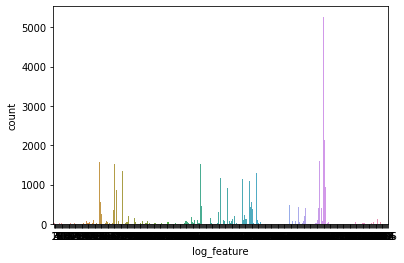

In [44]:
sns.countplot(x = 'log_feature' , data = log_feature)

# Analysis resourse type

In [45]:
resource_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21076 entries, 0 to 21075
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             21076 non-null  int64 
 1   resource_type  21076 non-null  object
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


In [46]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [47]:
# clean the data of resourse type

resource_type['resource_type'] = resource_type['resource_type'].str.lstrip('resource_type').astype('int')
resource_type.head()

,id,resource_type
0,6597,8
1,8011,8
2,2597,8
3,5022,8
4,6852,8


In [48]:
resource_type['resource_type'].value_counts()

8     10268
2      8918
6       582
7       498
4       330
9       190
3       145
10       73
1        58
5        14
Name: resource_type, dtype: int64

In [49]:
resource_type = pd.get_dummies(resource_type , columns=['resource_type'])
resource_type.head()

,id,resource_type_1,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,resource_type_8,resource_type_9,resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


# Analysis severity type

In [50]:
severity_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18552 entries, 0 to 18551
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             18552 non-null  int64 
 1   severity_type  18552 non-null  object
dtypes: int64(1), object(1)
memory usage: 290.0+ KB


In [51]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [52]:
# cleaning the severity data

severity_type['severity_type'] = severity_type['severity_type'].str.lstrip('severity_type').astype('int')
severity_type.head()

,id,severity_type
0,6597,2
1,8011,2
2,2597,2
3,5022,1
4,6852,1


In [53]:
severity_type['severity_type'].value_counts()

2    8737
1    8728
4    1014
5      65
3       8
Name: severity_type, dtype: int64

In [54]:
# one hot encoding
severity_type = pd.get_dummies(severity_type , columns=['severity_type'])
severity_type.head()

,id,severity_type_1,severity_type_2,severity_type_3,severity_type_4,severity_type_5
0,6597,0,1,0,0,0
1,8011,0,1,0,0,0
2,2597,0,1,0,0,0
3,5022,1,0,0,0,0
4,6852,1,0,0,0,0


# analysis submission data

In [55]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11171 entries, 0 to 11170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         11171 non-null  int64
 1   predict_0  11171 non-null  int64
 2   predict_1  11171 non-null  int64
 3   predict_2  11171 non-null  int64
dtypes: int64(4)
memory usage: 349.2 KB


In [56]:
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


# **Feature Engineering**

In [57]:
event_type = event_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

event_type.head()

,id,sum_event_type
0,6597,11
1,8011,15
2,2597,15
3,5022,26
4,6852,26


In [58]:
log_feature = log_feature.groupby('id', sort=False).agg(count_log_feature=('log_feature','count'), 
                                                        sum_volume=('volume', 'sum'),
                                                        mean_volume=('volume', 'mean')
                                                      ).reset_index()
log_feature.head()

,id,count_log_feature,sum_volume,mean_volume
0,6597,1,6,6.000000
1,8011,1,7,7.000000
2,2597,1,1,1.000000
3,5022,4,10,2.500000
4,6852,3,5,1.666667


In [59]:
resource_type = resource_type.groupby('id', sort=False).agg(sum).add_prefix('sum_').reset_index()

resource_type.head()

,id,sum_resource_type_1,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


In [60]:
dfs = [data, log_feature, severity_type, resource_type, event_type] 
df1 = pd.merge(data , log_feature)
df2 = pd.merge(df1 , severity_type)
df3 = pd.merge(df2 , resource_type)
result = pd.merge(df3 , event_type)

result.shape

(18552, 23)

In [61]:
data.shape , log_feature.shape , severity_type.shape , resource_type.shape , event_type.shape

((18552, 4), (18552, 4), (18552, 6), (18552, 11), (18552, 2))

In [62]:
result.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,1,0,0,26
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,1,0,0,0,0,0,1,0,0,101


In [63]:
result.isnull().sum()

id                          0
location                    0
fault_severity          11171
istrain                     0
count_log_feature           0
sum_volume                  0
mean_volume                 0
severity_type_1             0
severity_type_2             0
severity_type_3             0
severity_type_4             0
severity_type_5             0
sum_resource_type_1         0
sum_resource_type_2         0
sum_resource_type_3         0
sum_resource_type_4         0
sum_resource_type_5         0
sum_resource_type_6         0
sum_resource_type_7         0
sum_resource_type_8         0
sum_resource_type_9         0
sum_resource_type_10        0
sum_event_type              0
dtype: int64

# Now its time to split the train and test data set

In [64]:
train = result[result['istrain'] == 1]
train.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
0,14121,118,1.0,1,2,38,19.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
1,9320,91,0.0,1,2,316,158.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
2,14394,152,1.0,1,2,2,1.000000,0,1,0,...,1,0,0,0,0,0,0,0,0,69
3,8218,931,1.0,1,3,22,7.333333,1,0,0,...,0,0,0,0,0,0,1,0,0,26
4,14804,120,0.0,1,9,12,1.333333,1,0,0,...,1,0,0,0,0,0,1,0,0,101


In [65]:
test = result[result['istrain'] == 0]
test.head()

,id,location,fault_severity,istrain,count_log_feature,sum_volume,mean_volume,severity_type_1,severity_type_2,severity_type_3,...,sum_resource_type_2,sum_resource_type_3,sum_resource_type_4,sum_resource_type_5,sum_resource_type_6,sum_resource_type_7,sum_resource_type_8,sum_resource_type_9,sum_resource_type_10,sum_event_type
7381,11066,481,NaN,0,4,98,24.5,0,1,0,...,1,0,0,0,0,0,0,0,0,69
7382,18000,962,NaN,0,2,29,14.5,1,0,0,...,0,0,0,0,0,0,1,0,0,26
7383,16964,491,NaN,0,2,21,10.5,0,1,0,...,1,0,0,0,0,0,0,0,0,69
7384,4795,532,NaN,0,3,3,1.0,0,0,0,...,0,1,0,0,0,0,0,1,0,37
7385,3392,600,NaN,0,2,8,4.0,0,1,0,...,0,0,0,0,0,0,1,0,0,15


# Split the data into training and test sets

In [66]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

X = train.drop(columns='fault_severity')

# Prediction target - Training data
y = train['fault_severity']

# Selected features - Test data
x = test.drop(columns='fault_severity')

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Train Validation Split Complete")

Train Validation Split Complete


# Scalling

In [67]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)

In [68]:
X_train.shape , X_valid.shape

((5904, 22), (1477, 22))

In [69]:
print(tf.__version__)

2.1.0


# Data Modelling

# Training the model using RNNs ( Recurrent Neural Networks ) Neural network

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Embedding
from tensorflow.keras.layers import SimpleRNN , RNN
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential()
model.add(Embedding(input_dim=1000, output_dim=64))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(SimpleRNN(28))

model.add(Dense(10 , activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 28)                2604      
_________________________________________________________________
dense (Dense)                (None, 10)                290       
Total params: 66,894
Trainable params: 66,894
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(optimizer = 'adam' , loss ='sparse_categorical_crossentropy'  , metrics = ['categorical_accuracy'])

In [72]:
model.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 50)

Train on 5904 samples, validate on 1477 samples
Epoch 1/50
5904/5904 [==============================] - 3s 529us/sample - loss: 3.3514 - categorical_accuracy: 0.3310 - val_loss: 1.5634 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
5904/5904 [==============================] - 1s 121us/sample - loss: 1.2205 - categorical_accuracy: 0.0000e+00 - val_loss: 1.0959 - val_categorical_accuracy: 0.0020
Epoch 3/50
5904/5904 [==============================] - 1s 119us/sample - loss: 1.0223 - categorical_accuracy: 0.0268 - val_loss: 0.9936 - val_categorical_accuracy: 0.1381
Epoch 4/50
5904/5904 [==============================] - 1s 119us/sample - loss: 0.9446 - categorical_accuracy: 0.6629 - val_loss: 0.9258 - val_categorical_accuracy: 0.9926
Epoch 5/50
5904/5904 [==============================] - 1s 119us/sample - loss: 0.8972 - categorical_accuracy: 0.9941 - val_loss: 0.8876 - val_categorical_accuracy: 1.0000
Epoch 6/50
5904/5904 [==============================] - 1s 123us/sample - loss: 0.86

5904/5904 [==============================] - 1s 114us/sample - loss: 0.7718 - categorical_accuracy: 0.9875 - val_loss: 0.7774 - val_categorical_accuracy: 0.9953
Epoch 49/50
5904/5904 [==============================] - 1s 114us/sample - loss: 0.7712 - categorical_accuracy: 0.9892 - val_loss: 0.7761 - val_categorical_accuracy: 0.9919
Epoch 50/50
5904/5904 [==============================] - 1s 118us/sample - loss: 0.7717 - categorical_accuracy: 0.9881 - val_loss: 0.7765 - val_categorical_accuracy: 0.9919


In [73]:
model.history.history

{'loss': [3.351364643593145,
  1.220467450495981,
  1.0223302786266255,
  0.9445998051625281,
  0.8971526676077184,
  0.8685788811060794,
  0.8395182512963044,
  0.8250688912099616,
  0.8180788865257408,
  0.8118650412494898,
  0.8073429080852002,
  0.8020291233127356,
  0.7902211104305132,
  0.7862969622379397,
  0.7842245265074216,
  0.7825563341621461,
  0.7814039101768638,
  0.780500799659791,
  0.779768657555102,
  0.7790749129564135,
  0.7786470289798934,
  0.7781306130453177,
  0.7777542124595745,
  0.7771466167638619,
  0.7771232824338484,
  0.7766922820551285,
  0.7764513944868796,
  0.7762410899164877,
  0.7756165159427053,
  0.7756006775832758,
  0.7751884919194995,
  0.7750678319271987,
  0.774697137395864,
  0.7744212589935882,
  0.7743761713911848,
  0.774036109285949,
  0.7734465088624618,
  0.7732910832092368,
  0.7734891244874091,
  0.7732695909696543,
  0.7729349879391472,
  0.7727232557648243,
  0.7732538462977422,
  0.7720532890580857,
  0.7721426923100542,
  0.7725

In [74]:
loss = pd.DataFrame(model.history.history)

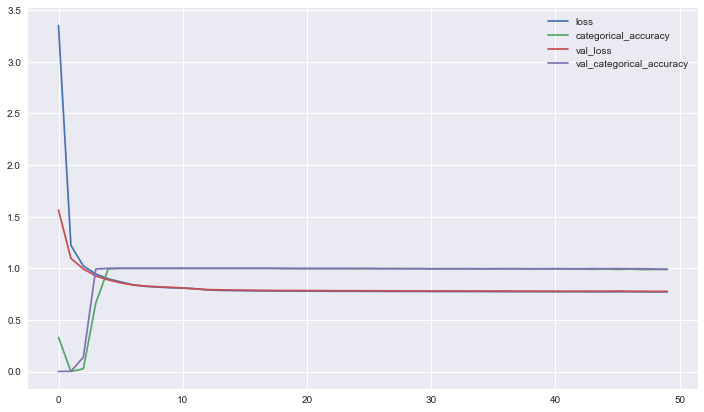

In [75]:
plt.style.use('seaborn')
loss.plot(figsize = (12,7))

In [76]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , explained_variance_score , r2_score

In [77]:
y_preds = model.predict(y_valid)

In [78]:
err = pd.DataFrame(y_valid.values.reshape(1477,1) - y_preds)

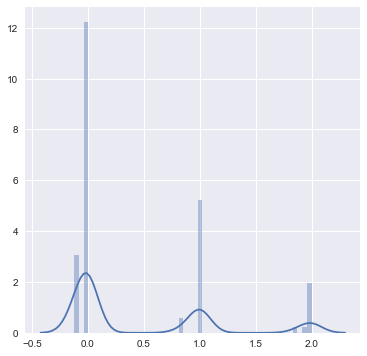

In [79]:
plt.figure(figsize=(6,6))
sns.distplot(err , bins = 50)

* The above line graph shows that the model is perfectly trainined upto the 30 epoches after that it fluctuates at some epoches then again it shows the linear dependency with loss and categorical accuracy

* And the next graph shows the error which means the difference between predicted labels and true labels and shows on a distributed graph

# Now lets see what will happen to the accuracy of the model if we change the hyperparameters or increase/descrese the number of layers.

## Tuning the hyperparameters or changing the number of layers

In [80]:
# changing the number of layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Embedding
from tensorflow.keras.layers import SimpleRNN , RNN
from tensorflow.keras.optimizers import Adam

model_2 = tf.keras.Sequential()
model_2.add(Embedding(input_dim=1000, output_dim=64))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_2.add(SimpleRNN(120))

model_2.add(Dense(10 , activation='softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 120)               22200     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1210      
Total params: 87,410
Trainable params: 87,410
Non-trainable params: 0
_________________________________________________________________


In [81]:
# compile the model
model_2.compile(optimizer = 'adam' , loss ='sparse_categorical_crossentropy'  , metrics = ['accuracy'])

In [82]:
model_2.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 50)

Train on 5904 samples, validate on 1477 samples
Epoch 1/50
5904/5904 [==============================] - 4s 647us/sample - loss: 0.9839 - accuracy: 0.6348 - val_loss: 0.8691 - val_accuracy: 0.6486
Epoch 2/50
5904/5904 [==============================] - 2s 278us/sample - loss: 0.8552 - accuracy: 0.6480 - val_loss: 0.8598 - val_accuracy: 0.6486
Epoch 3/50
5904/5904 [==============================] - 2s 274us/sample - loss: 0.8350 - accuracy: 0.6448 - val_loss: 0.8134 - val_accuracy: 0.6486
Epoch 4/50
5904/5904 [==============================] - 2s 275us/sample - loss: 0.8039 - accuracy: 0.6424 - val_loss: 0.8042 - val_accuracy: 0.6486
Epoch 5/50
5904/5904 [==============================] - 2s 281us/sample - loss: 0.7927 - accuracy: 0.6506 - val_loss: 0.7872 - val_accuracy: 0.6486
Epoch 6/50
5904/5904 [==============================] - 2s 281us/sample - loss: 0.7863 - accuracy: 0.6535 - val_loss: 0.7930 - val_accuracy: 0.6486
Epoch 7/50
5904/5904 [==============================] - 2s 286us

In [83]:
model_2.history.history

{'loss': [0.9839192654705307,
  0.8552053281608313,
  0.8350405793202925,
  0.8038661979078278,
  0.7926527476569178,
  0.7863273346004124,
  0.7799673208053196,
  0.7775473714197877,
  0.7755756864379738,
  0.7771382834207075,
  0.7766266017748411,
  0.7762215717375117,
  0.7739844771258553,
  0.7747721193928706,
  0.7767338646136648,
  0.7729059853527928,
  0.7685524238157402,
  0.7704360914747244,
  0.7667082506143627,
  0.7646038713170907,
  0.7630579458665718,
  0.7669700839655186,
  0.764511002757685,
  0.7650930529364403,
  0.7633280505332843,
  0.7641514013130167,
  0.764057298016742,
  0.7621493342769178,
  0.7641243710104366,
  0.7615543810655754,
  0.7591832372231212,
  0.7599603326986153,
  0.7608371737203624,
  0.7593277831710774,
  0.7590892625048877,
  0.7618298861715529,
  0.7609513923727723,
  0.7595544047148893,
  0.7582649729116177,
  0.7634696051034178,
  0.7586464487763278,
  0.7583205601387231,
  0.7585163505742867,
  0.7556139350260499,
  0.7570702120217527,
  0.

In [84]:
loss_2 = pd.DataFrame(model_2.history.history) 

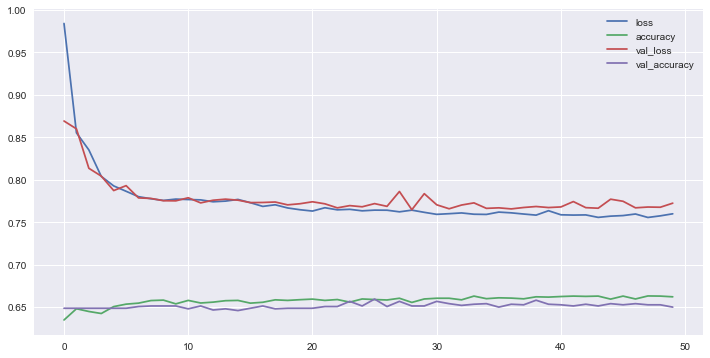

In [85]:
loss_2.plot(figsize=(12,6))

# Evaluation and predictions on tuned hyperparamter model

In [86]:
from sklearn.metrics import mean_absolute_error , mean_squared_error , explained_variance_score , r2_score

In [87]:
y_preds_2 = model_2.predict(X_valid)

In [88]:
err_2 = pd.DataFrame(y_valid.values.reshape(1477 , 1) - y_preds_2)

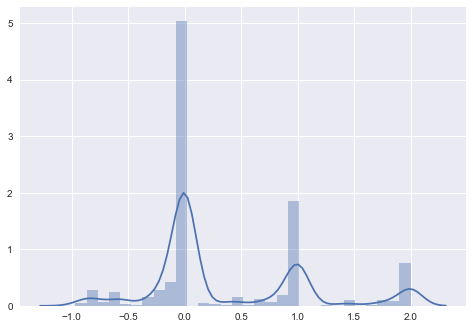

In [89]:
sns.distplot(err_2 ,  bins = 30 )

* After tuning the hyperparameters ,  we see a linearly dependency curve on accuracy and val_accuracy.
* Also it clearly shows that loss and val loss is decrease with the increase of number of epoches . The model is trained with 50 epoches. And by predicting the curve we can say that if we increase the number of epoches the loss and val loss will surely decrease and accuracy and val accuracy will going to increase.

# Now train the model with different optimizer like SGD  , RMSprop having tuned learning rate and momentum

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Embedding , Dropout
from tensorflow.keras.layers import SimpleRNN , RNN
from tensorflow.keras.optimizers import Adam , RMSprop , SGD 
from tensorflow.keras.callbacks import EarlyStopping

model_2 = tf.keras.Sequential()
model_2.add(Embedding(input_dim=1000, output_dim=64))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_2.add(SimpleRNN(120))
model.add(Dropout(0.5))

model_2.add(Dense(10 , activation='softmax'))

early_stop = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 25)

opt = RMSprop(learning_rate = 0.0001 , momentum = 0.99)


model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 120)               22200     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1210      
Total params: 87,410
Trainable params: 87,410
Non-trainable params: 0
_________________________________________________________________


In [119]:
# compile the model
model_2.compile(optimizer = opt , loss ='sparse_categorical_crossentropy'  , metrics = ['accuracy'])

In [120]:
model_2.fit(x = X_train , y = y_train.values , validation_data = (X_valid , y_valid.values) , batch_size = 128 , epochs = 50 , callbacks = [early_stop])

Train on 5904 samples, validate on 1477 samples
Epoch 1/50
5904/5904 [==============================] - 3s 553us/sample - loss: 1.0699 - accuracy: 0.6150 - val_loss: 0.8856 - val_accuracy: 0.6486
Epoch 2/50
5904/5904 [==============================] - 1s 239us/sample - loss: 0.8367 - accuracy: 0.6479 - val_loss: 0.8065 - val_accuracy: 0.6493
Epoch 3/50
5904/5904 [==============================] - 1s 244us/sample - loss: 0.8077 - accuracy: 0.6450 - val_loss: 0.8212 - val_accuracy: 0.6479
Epoch 4/50
5904/5904 [==============================] - 2s 262us/sample - loss: 0.8040 - accuracy: 0.6524 - val_loss: 0.8047 - val_accuracy: 0.6520
Epoch 5/50
5904/5904 [==============================] - 1s 251us/sample - loss: 0.8009 - accuracy: 0.6502 - val_loss: 0.8316 - val_accuracy: 0.6500
Epoch 6/50
5904/5904 [==============================] - 1s 248us/sample - loss: 0.8068 - accuracy: 0.6472 - val_loss: 0.8054 - val_accuracy: 0.6479
Epoch 7/50
5904/5904 [==============================] - 1s 246us

In [121]:
losses2 = pd.DataFrame(model_2.history.history)

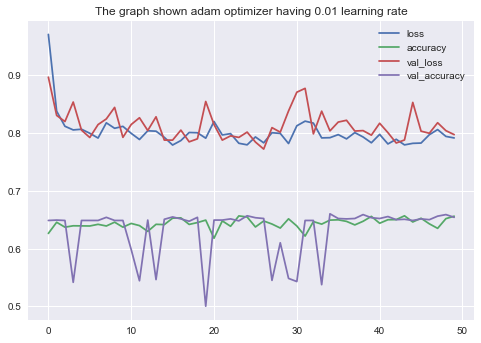

In [97]:
losses2.plot()
plt.title('The graph shown adam optimizer having 0.01 learning rate');

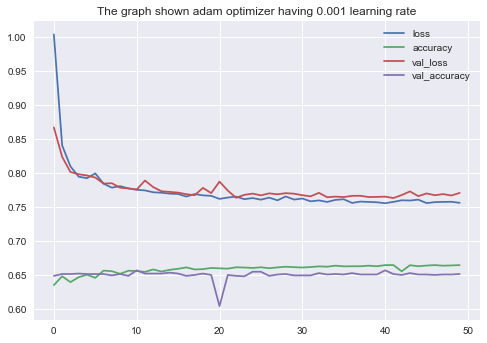

In [102]:
losses2.plot()
plt.title('The graph shown adam optimizer having 0.001 learning rate');

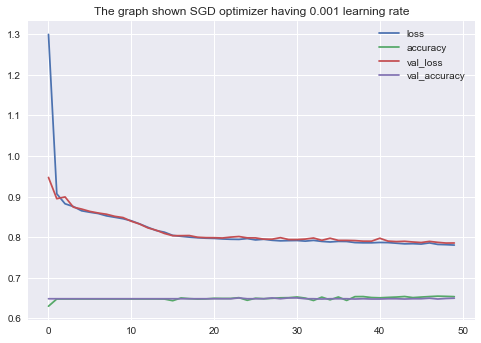

In [107]:
losses2.plot()
plt.title('The graph shown SGD optimizer having 0.001 learning rate');

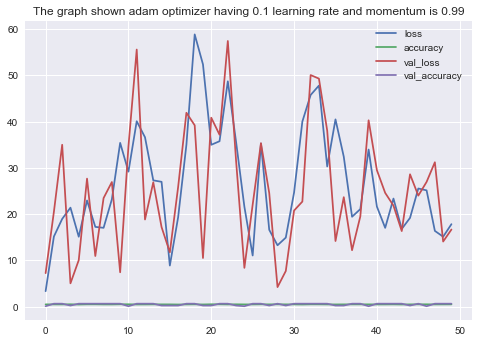

In [112]:
losses2.plot()
plt.title('The graph shown adam optimizer having 0.1 learning rate and momentum is 0.99');

* wrost case

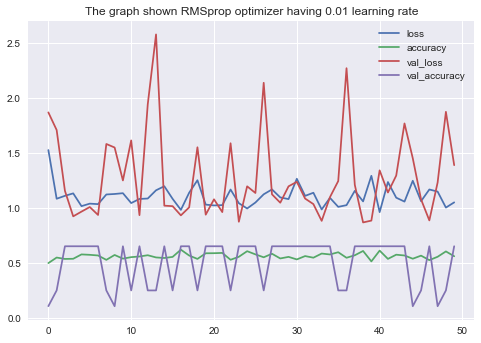

In [117]:
losses2.plot()
plt.title('The graph shown RMSprop optimizer having 0.01 learning rate');

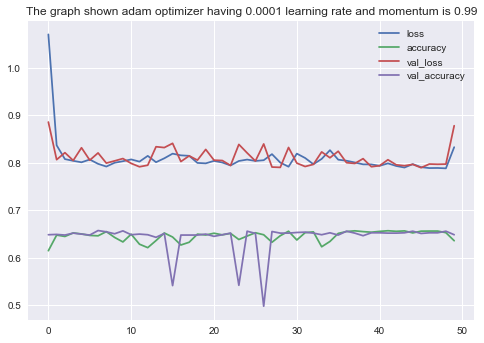

In [122]:
losses2.plot()
plt.title('The graph shown adam optimizer having 0.0001 learning rate and momentum is 0.99');

* From the above graps summary we can conclude that adam is the best optimizer when used at learning rate 0.01
* And after that RMSprop when used at learning rate 0.0001 and momentum = 0.99

# Thank You